Please fill in your name and that of your teammate.

You: Albin Aliu

Teammate: Christoph Jutzet

# Introduction

Welcome to the sixth lab. Last week we attacked classification problems expanding the concept of LDA, interpreting the data as generated from probability distributions, into Naïve Bayes. Today we follow the same plan from the perspective of the _margin_ , starting with the Perceptron expanding it into the Support Vector Machine.

You will notice we will not implement the learning algorithm this time, because SVMs are solved through quadratic programming and that is not fun. And believe me, I am striving to keep the assignments _fun_ so far, but feel free to check out quadratic programming yourself.

So instead we will focus on the ample new glossary, then implementing the SVM objective function, and using off-the-shelf optimizers for training. Enjoy!

## Two quick notes

**FROM NOW ON:** take a habit of loading your default libraries, plotting style and external tools at the top of the file (here works). I will not mention it further in the next labs.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")

**MOREOVER:** several people keep losing points because they write (or likely: copy+paste) some of the definitions but do not follow through the question with the explanation in English. Let me be clear: such trick at the exam is worth zero points.

- Yes: I understand you would like a partial score because you pasted the right equation.
- Yes: sometimes I am granting partial points at the exercises if I feel later the concept could have been understood, as we reiterate the same topics over and over.
- No: this will not happen at the exam. Goal of the test is to evaluate your understanding of the topic, so mechanical skills are not going to be rewarded. Including math you are unable to read has no value.

Write the explanations when the questions asks for them, they are more important than the equation. That's it. I hope you understand my stand here, and you will ready yourselves for the exam.

### How to pass the lab?

Below you find the exercise questions. Each question awarding points is numbered and states the number of points like this: **[0pt]**. To answer a question, fill the cell below with your answer (markdown for text, code for implementation). Incorrect or incomplete answers are in principle worth 0 points: to assign partial reward is only up to teacher discretion. Over-complete answers do not award extra points (though they are appreciated and will be kept under consideration). Save your work frequently! (`ctrl+s`)

**You need at least 18 points (out of 27 available) to pass** (66%).

# 1. Fundamentals

#### 1.1 **[1pt]** Write the equation for the margin (use latex).

Let $(x,y) \in \mathbb{R}^n \times \{-1, +1\}$ be a labeled example. The *margin* of example $(x,y)$ w.r.t $f$ (an ffine function) is

$$y \cdot f(x)$$

*I made it myself easy here by just writing the equation of the margin of one point, since it was not explicitely stated **what** margin we need to write down. There is however $\gamma$ defined like in the slides, which is the smallest margin of all of them, blabla, alright here it is: $\gamma = \min_{1\leq i \leq n} \{y_i \cdot f(x_i)\}$*


#### 1.2 **[2pt]** Write the equation for the maximum margin separation (use latex) and explain it in English.

$$
\arg\max_{w,b} \{\gamma\}\ \ \text{s.t.}\ \ \forall i \in \{1,...,n\}:
\\ y_i \cdot (\langle w, x_i \rangle + b) \geq \gamma,\ \ \|w\| = 1
$$

This just means: for a given linear seperable dataset $D$, argmax returns the set of all $w$ and $b$ s.t. $\gamma_{w,b}$ attains a maximum, i.e. you get the set $\{ (w,b) \in \mathbb{R}^p \times \mathbb{R}\ |\  \forall w', \forall b' : \gamma_{w,b} \geq \gamma_{w',b'}\}$. Also, we have the normalization of $\|w\| = \|w'\| = 1$. And of course, the maximum should attain $\forall i \in \{1,...,n\}$.

#### 1.3 **[1pt]** When is an example (in a dataset) considered a Support Vector? Use latex, then explain it in English.

An example $(x_i , y_i )$ is a Support Vector SV $\iff y_i\cdot f(x_i) = 1$

They have a distance of $\gamma$ to the seperating hyperplane.
Since $\|w\| = 1 \Rightarrow \gamma = 1$


#### 1.4 **[1pt]** Explain why SVMs ignore examples that are not Support Vectors.

Because they're not of particular interest for us because their margins are larger than $\gamma$, thus they're not part of our boundary (defined by margin $\gamma$). 

#### 1.5 **[2pt]** Define the following concepts (in English): Quadratic Program, Slack Variable, Multiobjective Optimization.

**Quadratic Program**
Process of minimizing or maximizing (i.e. **optimizing**) a linearly constrained quadratic optimization problem (because the function to max or min is quadratic). 

**Slack Variable**
are variables $\xi_i$ which measure for each **misclassified** point $x \in D$ the violation size of a point (the distance to the boundary on "the other side")

**Multiobjective Optimization**
When you're trying to optimize two or more "objects", in our example we try to optimize (a quadratic) function by minimzing it and also trying to optimize (minimize) a (or the) sum of all viaolations.


#### 1.6 **[3pt]** Write the full formula for the Soft Margin SVM (geometrical approach; use latex) and explain in English the role of the hyperparameter C (particularly: what do high or low values mean for the SVM).

$$
\arg\min_{w,b,\xi} \{\frac{1}{2}\|w\|^2 + C\cdot \sum_{i=1}^{n} \xi_i\}
$$
$$
\text{s.t. } \forall \in \{1,...,n\}: y_i \cdot (\langle w,x_i\rangle + b ) \geq 1 - \xi_i \text{and} \xi_i \geq 0
$$

Here we have $C$ as an hyperparameter, *a user set parameter*,  to control the relative importance of the second objective (the sum of all violations). Of course, $C > 0$ and the larger it is, the more importance we give the violations to be small. The smaller $C$ is, the more importance we give the boundary/margin to be small.

#### 1.7 **[2pt]** Write the objective function for the Soft Margin SVM (use latex) using the Regularized Empirical Risk Minimization approach and a Squared Hinge Loss for `L(m)`.

This is no copy-paste, think!

$$
\arg\min_{w,b} \Big\{\frac{1}{2}\|w\|^2 + C\cdot \sum_{i=1}^{n} \big(\max\{0, 1-y_i \cdot (\langle w, x_i \rangle + b ) \}^2 \big )\Big\}
$$

# 2. Soft Margin SVM

- Following what we learned in the last exercise: all of the questions below need to be solved using Pandas and no Python loop (`for`, `while`, etc).
- Let's classify the Iris dataset with a hand-made SVM. Working with margins though means we need to set up once again for **binary classification**. Last time we used the categorical feature type, but this time we need the numerical values for the two classes to be of integer type in $\{-1, 1\}$, because we work with margin calculations. How would you do it? Here's one way to get it done:

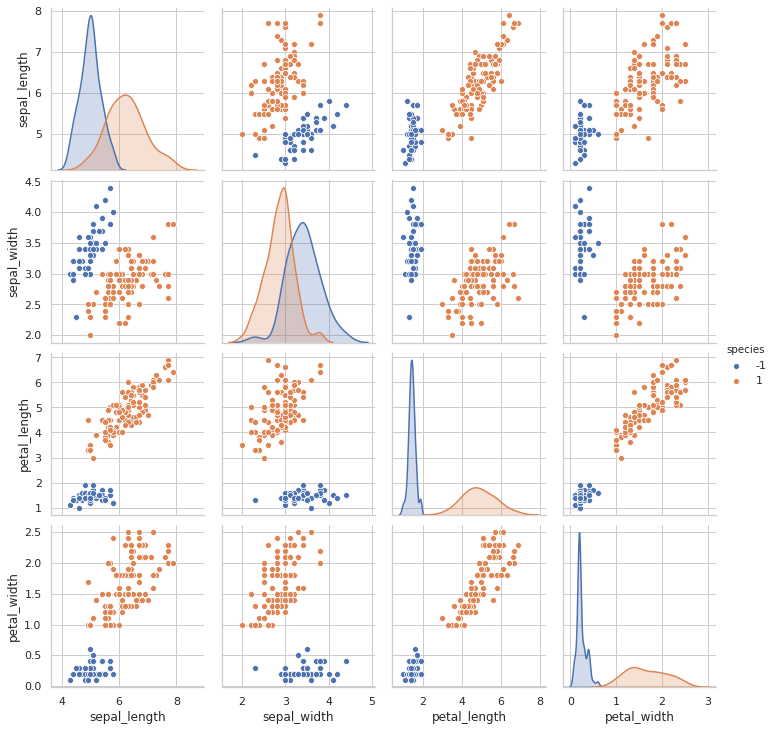

In [2]:
df = sns.load_dataset('iris')
# sns.pairplot(df, hue='species')

df.loc[df['species'] == 'setosa', 'species'] = -1
df.loc[df['species'] != -1, 'species'] = 1
df['species'] = pd.to_numeric(df['species'])
df
sns.pairplot(df, hue='species')

Also, do not forget to **split your data** into train set and test set, because using the wrong data you will fail the question. This was introduced in the last lab and will hold until the end of the course. You can copy the code from last submission.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2) # 80-20 split

#### 2.1 **[1pt]** Write a Python function that takes in input a row from the Iris dataset (concatenation of $x_i$ and $y_i$), and a parametrization $(w, b)$, and returns the margin.

This is slightly different from what you did so far: rather than pre-splitting the inputs from the labels, you should do the splitting inside the function. You can test the method by passing a (full) single row of the dataset (e.g. `iloc[0]`: notice you do not drop the label). As you should expect, the correct output is one number.

In [4]:
def gamma(pt, param):
  x = pt[:-1]
  y = pt[-1:]
  w = param[0]
  b = param[1]
  
  return y * (np.dot(w, x) + b);

params_p = lambda p: (np.random.uniform(-5, 5, (1,p)),np.random.uniform(-5, 5))
params = lambda: params_p(4)

gamma(train.iloc[0], params())

species   -9.867938
Name: 83, dtype: float64

#### 2.2 **[1pt]** Write a Python function that takes in input an entire dataset and computes the margins for all points. Use Pandas `apply()`, no Python loops.

To [unit-test](https://en.wikipedia.org/wiki/Unit_testing) these functions, get used to generating bogus parameters (of the correct size), e.g. using `np.random`. The correct output is a Series 120 numbers long (for a 80-20 split, and running of course on the train set).

In [5]:
def _margins(dataset, params):
  w,b = params
  return dataset.apply(lambda x: gamma(x, (w,b)), axis = 1)

margins = _margins(train, params())
margins

,species
83,-31.856777
60,-22.820564
44,19.744538
138,-30.534702
82,-26.792931
...,...
32,19.181012
67,-28.134073
10,18.685881
30,17.121246


#### 2.3 **[1pt]** Write a Python function that computes the Squared Hinge Loss for the whole dataset. Re-use the functions defined in answering the previous questions.

- Feel free to define it in two steps, the first being the Loss function for a single number, the second another round of `apply()`.
- You will likely see a lot of zeros in the result, together with some high numbers. _Think: why so?_ Look at the Loss function.
- You can either `apply()` a simple lambda to the output of `margins()`, or a more complex lambda to the dataset directly.

In [6]:
_sqd_hinge_loss = lambda dataset: dataset.apply(lambda m: np.maximum(0,1-m)**2)

sqd_hinge_loss = _sqd_hinge_loss(margins)

sqd_hinge_loss

,species
83,1079.567770
60,567.419255
44,0.000000
138,994.437461
82,772.447029
...,...
32,0.000000
67,848.794211
10,0.000000
30,0.000000


#### 2.4 **[2pt]** Write a Python function computing the soft-margin objective function for parametrization $(w, b)$ and hyperparameter `c`. Do not write a loop over the data points, use Pandas instead.

You should be looking for the "unconstrained convex optimization problem" form. Consider the `linalg` module of numpy already gives you an implementation for the (standard) Euclidean `norm` (i.e. _2-norm_ ). More on norms [here](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm).  
For testing, a simple `c=1` will work.

In [0]:
from numpy import linalg as LA

def _soft_margin_svm(dataset, param, c):
  w,b = param
  left = (1/2) * (LA.norm(w)**2)
  
  margins = _margins(dataset, (w,b))
  sqd_hinge_loss = _sqd_hinge_loss(margins)

  right = c * sqd_hinge_loss.sum()

  return (left + right)[0]


#### 2.5 **[4pt]** Train the SVM using Parameter Guessing and print the number of misclassified points.

- Whip back up the parameter guessing strategy from the first lab and estimate the parameters that _minimize the SVM optimization function_ defined above.  
- The classification with SVM is exactly the same as the Perceptron: positive margin is correct classification, negative is incorrect classification. Use the correct dataset!
- You can make the next question easier by defining two Python functions: `train_svm(dset, c, ntries)` and `test_svm(params, dset)`.
- You don't need many guesses to consistently get a decent margin here, try `ntries=100` and `c=1` as defaults.

In [8]:
def train_svm(dset, c, ntries):
  min_sms = np.Infinity # higher than highest possible
  best_guesses = []
  l = len(dset.columns) - 1
  for _ in range(ntries):
    guess = params_p(l);
    soft_margin_svm = _soft_margin_svm(dset, guess, c)
    if soft_margin_svm < min_sms:
        min_sms = soft_margin_svm
        best_guesses.append(guess)
          
  #just return the last guess, which is the best
  best = best_guesses[len(best_guesses)-1]
  w = best[0][0]
  b = best[1]
  return (w,b)

w,b = train_svm(train, 1, 100)

predictions = test.apply(lambda x: 1 if(np.dot(w, x[:-1]) + b) > 0 else -1, axis=1)

predictions.eq(test.iloc[:,-1]).value_counts()

True    30
dtype: int64

#### 2.6 **[3pt]** Train another SVM, this time using only two features of the Iris dataset: `petal_length` and `petal_width`. Plot the decision boundary of the trained parameters, on top of a scatterplot of the (2D) test set.

- You cannot plot higher-dimensional separation hyperplanes in 2D unless (a) they are perpendicular to the features you want to plot, or (b) you project the points parallel to the hyperplane. So if you want to plot you need to re-train for 2D data.
- Careful because starting next week I will resume calling it "the data", and using the wrong dataset (train set) when evaluating the model will cause you to fail the question.
- Start by generating the `train_2d` and `test_2d` datasets. Then try running your SVM train, and if you hardcoded the number of features just go back and refactor your code.
- You are learning parameters `w` and `b`: remember to convert to `m` and `q` for plotting.
- Understand that you are not "training" the SVM as much as guessing one that is right. If you want a nice-looking margin you may need to increase the number of guesses.
- Feel free to play with `C`. A value of `1.0` here still works, but many applications may need it as high as `1e5` or as low as `1e-5`.

In [0]:
#code by lecturer
def wb2mq(w, b):
    assert len(w) == 2, "This implementation only works in 2D"
    assert w[0] != 0 and w[1] != 0 and b != 0 # simplify
    return [w[0]/-w[1], b/-w[1]] # m and q

def params2boundary(w, b):
    m, q = wb2mq(w, b)
    print(f"m: {m}, q: {q}")
    return lambda x: m*x + q

w: [ 2.34630661 -2.22080583], b: -4.672517800125865
m: 1.0565113714587946, q: -2.103974033573108


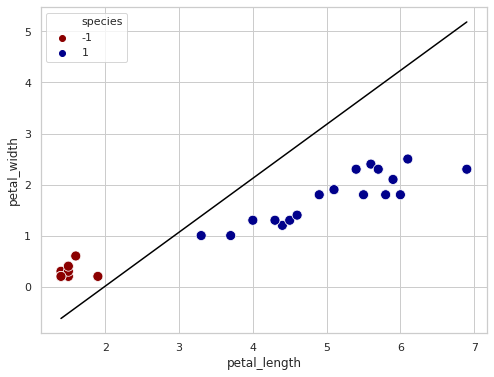

In [17]:
new_train_set = train.drop(columns=['sepal_length', 'sepal_width'])

w,b = train_svm(new_train_set, 1, 100)

sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")


x1 = test['petal_length']
x2 = test['petal_width']
y = test['species']

sns.scatterplot(x1, x2,
  hue=y, # let's use different colors for the two classes
  palette=sns.color_palette(['darkred', 'darkblue']),
  s=100)

# we can use the splat to separate the bias (last element)
print(f"w: {w}, b: {b}")
boundary = params2boundary(w, b)

gl_boundary = [boundary(inp) for inp in x1]
sns.lineplot(x1, gl_boundary, color='black')




#### 2.7 **[2pt]** Classify the 2D dataset using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/svm.html). Mandatory: (i) use the `LinearSVC` implementation (as we did not study kernels yet), (ii) explicitly require to use the same Loss function as in your hand-made implementation, (iii) use a custom value of `C` that tends to ignore margin violations, but without misclassifying data.

- In the name SVC, the 'C' stands for "classification", while SVR uses the same trick for regression (not to be used here). 
- LinearSVC uses `liblinear` underneat, while `SVC` uses `libsvm`. In some cases you may get better results with `SVC(kernel='linear')` than you do with LinearSVC, but the latter has a more flexible parametrization.
- Remember that this question requires you to access the right datasets for training and test phases, and that you need to split the `x` and `y` as seen last week with NB.  
- You may be tempted to try passing a straight `0` to `C`. Many implementations give errors for `C=0`, but you can get around it by passing a good enough approximation :) On the other hand, with a low enough `C` you will start getting misclassified points! Give it a try: do you understand why this happens? (spoiler hint: what happens if you maximize the margin with no restriction?)

In [11]:
from sklearn.svm import LinearSVC

x = train[['petal_length','petal_width']]
y = train['species']
_test = test[['petal_length','petal_width']]

# i tried using my own hand-made but it doesn't accept it and i couldn't find anything
# in the docs regarding user defined loss functions..
clf = LinearSVC(loss='squared_hinge', C=1)
clf.fit(x, y)

predictions = clf.predict(_test)
comparison = np.equal(predictions, test.iloc[:,-1].tolist())

"misclassified: "+str(len(comparison) - comparison.sum())

'misclassified: 0'

#### 2.8 **[1pt]** Plot the decision boundary of the SVM over the dataset.

w: [0.53647156 0.87103376], b: -1.9767275789868035
m: -0.6159021428240994, q: 2.2694041023167526


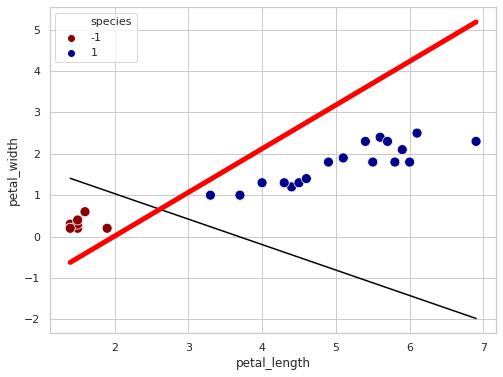

In [18]:
new_train_set = train.drop(columns=['sepal_length', 'sepal_width'])

w, b = [clf.coef_[0], clf.intercept_[0]]

x1 = test['petal_length']
x2 = test['petal_width']
y = test['species']

sns.scatterplot(x1, x2,
  hue=y, # let's use different colors for the two classes
  palette=sns.color_palette(['darkred', 'darkblue']),
  s=100)

# we can use the splat to separate the bias (last element)
print(f"w: {w}, b: {b}")
boundary = params2boundary(w, b)
sns.lineplot(x1, [boundary(inp) for inp in x1], color='black')


#MY BOUNDARY IN RED
sns.lineplot(x1, gl_boundary, color='red', lw=5)








# At the end of the exercise

Bonus question with no points! Answering this will have no influence on your scoring, not at the assignment and not towards the exam score -- really feel free to ignore it with no consequence. But solving it will reward you with skills that will make the next lectures easier, give you real applications, and will be good practice towards the exam.

The solution for this questions will not be included in the regular lab solutions pdf, but you are welcome to open a discussion on the Moodle: we will support your addressing it, and you may meet other students that choose to solve this, and find a teammate for the next assignment that is willing to do things for fun and not only for score :)

#### BONUS **[ZERO pt]** Train an SVM on the full Iris dataset (3 classes) using `libsvm`, and print the number of misclassified points. Play with `C` and see how this changes.

#### BONUS **[ZERO pt]** Train you hand-written SVM implementation using the [PEGASOS algorithm](https://github.com/ejlb/pegasos). Now you have a state-of-the-art implementation, better than available in the libraries.

To install pegasos (or any other GitHub repository) just switch to a local environment (as shown in the last lecture), then run (from your assignments folder):
```bash
pipenv install -e 'git+https://github.com/ejlb/pegasos.git#egg=pegasos'
```
Here is probably the most complete [guide to Pipenv](https://realpython.com/pipenv-guide). I do not expect a full read (I didn't); but if you need something from Pipenv, a quick `find` in that page will likely point you in the right direction.

### Final considerations

- SVM are optimal (when applicable). You are guaranteed to fall back to them at any opportunity, so get used to them.
- Easy problems can be often solved with parameter guessing, which means if you can solve a problem with parameter guessing it is easy :)
- The main limitation here is in handling non-linearities in the data, but this is a topic for next week.